In [2]:
%pylab inline
from qsystem_2 import PfbSoc, freq2reg
from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
#from averager_program import AveragerProgram
#from slab.instruments import InstrumentManager
import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
with ASM_Program() as p:
    p.memri(1, 1, 17)  # Get frequency value
    p.regwi(1, 2, 15000) #Set gain
    p.memri(1, 3, 18) # samples
    p.regwi(1,4,0x0) # b00000 -> phrst = 0, stdysel = 0, mode = 0, outsel = 00
    p.bitwi(1,4,4,"<<", 16)
    p.bitw (1,3,3,"|", 4)
    p.regwi(1,5,0)
    p.synci(200)
    
    p.regwi(0,1,0x4001)
    p.seti(0,0,1,0)
    
    p.memri (0,9,19) # sync length
    p.memri (0,4,33) # reps
    
    p.label("LOOP")
    p.set (6, 1, 1, 0, 0, 2, 3, 5)
    p.set (7, 1, 1, 0, 0, 2, 3, 5)
    
    p.mathi (1,2,2,"+",1000)
    p.sync (0, 9)
    p.loopnz (0,4,"LOOP")
    
    p.waiti(0,1000)
    p.read (0,3,"lower", 1) #Lower 32-bit on register $1 of page 3.
    p.read (0,3,"upper", 2)
    
    p.memwi (3,1,55)
    p.memwi (3, 2,56)
    
    p.seti(0,0,0,0)
    p.end()
p


// Program

      memri 1, $1, 17;
      regwi 1, $2, 15000;
      memri 1, $3, 18;
      regwi 1, $4, 0;
      bitwi 1, $4, $4 << 16;
      bitw 1, $3, $3 | $4;
      regwi 1, $5, 0;
      synci 200;
      regwi 0, $1, 16385;
      seti 0, 0, $1, 0;
      memri 0, $9, 19;
      memri 0, $4, 33;
LOOP: set 6, 1, $1, $0, $0, $2, $3, $5;
      set 7, 1, $1, $0, $0, $2, $3, $5;
      mathi 1, $2, $2, +, 1000;
      sync 0, $9;
      loopnz 0, $4, @LOOP;
      waiti 0, 1000;
      read 0, 3 lower $1;
      read 0, 3 upper $2;
      memwi 3, $1, 55;
      memwi 3, $2, 56;
      seti 0, 0, $0, 0;
      end ;

In [4]:
0b01001 <<16 | 18

589842

In [5]:
def get_mode_code(phrst, stdysel, mode, outsel, length):
    if phrst is None:
        phrst=0
    if stdysel is None:
        stdysel=1
    if mode is None:
        mode=0
    if outsel is None:
        outsel=0
    mc=phrst*0b10000+stdysel*0b01000+mode*0b00100+outsel
    return mc << 16 | length
    #return (stdysel << 15) | (mode << 14) | (outsel << 12) | (length <<0) # f'stdysel = {stdysel} , mode = {mode} , outsel = {outsel}, nsamp = {nsamp}'


In [6]:
get_mode_code(phrst=0,stdysel=1,mode=0,outsel=1,length=18)

589842

In [7]:
soc = PfbSoc('qsystem_2.bit')

In [8]:
fout = 200
with ASM_Program() as p:
    #p.memri(1, 1, 17)  # Get frequency value
#     p.regwi(1,1, p.freq2reg(fout))
#     p.regwi(1, 2, 15000) #Set gain
#     p.memri(1, 3, 18) # samples
#     p.regwi(1,4,0b01001) # b00000 -> phrst = 0, stdysel = 0, mode = 0, outsel = 00
#     p.bitwi(1,4,4,"<<", 16)
#     p.bitw (1,3,3,"|", 4)
#     p.regwi(1,5,0)
    p.set_wave(7, freq=p.freq2reg(fout), gain=15000, length=18, stdysel=1, mode=0, outsel=1, t=0, play=False)
    p.synci(200)
    
    p.regwi(0,1,0x4001)
    p.seti(0,0,1,0)
    
    p.memri (0,9,19) # sync length
    p.memri (0,4,33) # reps
    
    p.label("LOOP")
    #p.set (6, 1, 1, 0, 0, 2, 3, 5)
    #p.set (7, 1, 1, 0, 0, 2, 3, 5)
    p.set_wave(7,stdysel=1, mode=0, outsel=1,length=18,play=True)
    
    p.mathi (3,19,19,"+",1000)
    p.sync (0, 9)
    p.loopnz (0,4,"LOOP")
    
    p.waiti(0,1000)
    p.read (0,3,"lower", 1) #Lower 32-bit on register $1 of page 3.
    p.read (0,3,"upper", 2)
    
    p.memwi (3,1,55)
    p.memwi (3, 2,56)
    
    p.seti(0,0,0,0)
    p.end()

In [9]:
p


// Program

      regwi 3, $16, 167772160;                        freq
      regwi 3, $19, 15000;                        gain
      regwi 3, $21, 0;                        t = 0
      regwi 3, $18, 0;                        addr
      regwi 3, $20, 589842;                        stdysel = 1, mode = 0, outsel = 1, length = 18
      synci 200;
      regwi 0, $1, 16385;
      seti 0, 0, $1, 0;
      memri 0, $9, 19;
      memri 0, $4, 33;
LOOP: regwi 3, $18, 0;                        addr
      regwi 3, $20, 589842;                        stdysel = 1, mode = 0, outsel = 1, length = 18
      regwi 3, $21, 0;                        t = 0
      set 7, 3, $16, $17, $18, $19, $20, $21;                        ch = 7, out = $16,$18,$19,$20 @t = $21
      mathi 3, $19, $19, +, 1000;
      sync 0, $9;
      loopnz 0, $4, @LOOP;
      waiti 0, 1000;
      read 0, 3 lower $1;
      read 0, 3 upper $2;
      memwi 3, $1, 55;
      memwi 3, $2, 56;
      seti 0, 0, $0, 0;
      end ;

di_raw_sum = 55965, di_feed = 55965, di = 55965
dq_raw_sum = -16862, dq_feed = -16862, dq = -16862


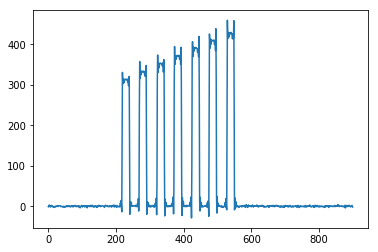

In [10]:
#########################
### Gaussian Envelope ###
#########################
# This asm file uses:
# |--------------------------------------------------|
# | tProc Out CH | DAC Tile | DAC Number | Generator |
# |--------------|----------|------------|-----------|
# |            6 |      229 |          2 |         5 |
# |            7 |      229 |          3 |         6 |
# |--------------------------------------------------|
#
# For readout:
# ADC 224 CH0, connected to readout 0, bit 14 of channel 0 tProc.
#
# tProcessor memory map:
# @17 : DAC frequency.
# @18 : DAC pulse length.
# @19 : sync value.
# @33 : Number or repetitions.
# @55 : Real part of average (feedback).
# @56 : Imaginary part of average (feedback).
xg_i = gauss(mu=150, si=80, length=300, maxv=30000)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
gen = soc.gens[5].load(addr=0,xin_i=xg_i, xin_q=xg_q)
gen = soc.gens[6].load(addr=0,xin_i=xg_i, xin_q=xg_q)

# Compute DDS frequency.

tmp = freq2reg(fs=soc.fs_dac,f=fout,B=32)
soc.tproc.single_write(addr=17,data=tmp)

# Compute pulse length.
Np = int(len(xg_i)/soc.gens[0].NDDS)
soc.tproc.single_write(addr=18,data=Np)

# tProc sync value to separate pulses.
Nsync = int(Np*2.4)
soc.tproc.single_write(addr=19,data=Nsync)

# Number of repetitions.
N = 7
soc.tproc.single_write(addr=33, data=N-1)

# Load program.
soc.tproc.stop()
#soc.tproc.load_program("gaussian_env.asm")
soc.tproc.load_asm_program(p)

# Number of total samples.
NTdac = N*len(xg_i)
NTadc = NTdac*soc.fs_adc/soc.fs_dac
NTadc_dec = int(NTadc/8)

# Configure readout.
soc.readouts[0].set_out("product")
soc.readouts[0].set_freq(fout)
soc.avg_bufs[0].config(address=0, length=900)
soc.avg_bufs[0].enable()

time.sleep(1)

# Start tProc.

soc.tproc.start()

time.sleep(1)

# Raw data.
[di_raw,dq_raw] = soc.get_decimated(ch=0, length=900)
plt.plot(di_raw)

# Accumulated data.
[di,dq] = soc.get_accumulated(ch=0, length=16)

# Feedback of accumulated data.
di_feed = soc.tproc.single_read(addr=55)
dq_feed = soc.tproc.single_read(addr=56)
if di_feed>2**31:
    di_feed = di_feed - 2**32
if dq_feed>2**31:
    dq_feed = dq_feed - 2**32
    
# Accumulate raw data in Python for comparison.
di_raw_sum = np.sum(di_raw)
dq_raw_sum = np.sum(dq_raw)

# Comparison.
print("di_raw_sum = %d, di_feed = %d, di = %d" %(di_raw_sum, di_feed, di[0]))
print("dq_raw_sum = %d, dq_feed = %d, dq = %d" %(dq_raw_sum, dq_feed, dq[0]))